# Data driven retail chain expansion - Location Analytics

* [Objective](#problem-def)
* [Data Acquisition](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results](#results)

## Objective

In this project, 
* visualize all major parts and areas of the Chennai City and try to predict an optimal location the for new bakery outlets.
* use various data science and analysis techniques to reach our goal of selecting optimal locations.


## Data Acquisition

The data and their respective data sources for our projects are discussed below,

1. Chennai city's major areas and neighbourhood

  **Data Source:** [Wikipedia](https://en.wikipedia.org/wiki/Areas_of_Chennai)

  **Data description:** We will initialize crawler to scrape and extract data and information about the areas and locality from the wikipedia web page.

2. Geographical coordinate of the areas

  **Data Source:** Python's [geocoder library](https://geocoder.readthedocs.io/index.html)

  **Data description:** Geocoder is a simple and consistent geocoding library written in Python. Dealing with multiple different geocoding provider such as Google, Bing, OSM and many more. Specifically, we will be using ArcGIS, as it is reliable and free.

3. To get nearby venues in each locality of Chennai city,

  **Data Source:** [Foursquare API](https://foursquare.com/)

  **Data description:** This API allows us to get information about all the venues in the neighbourhood of Chennai City. Foursquare Credentials is used to fetch the data.

https://developer.foursquare.com/docs/places-api/getting-started/

https://codekarim.com/node/55

### Importing necessary modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from collections import Counter
#import pickle

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Fetching neighborhoods - Wiki & geocoder

#### Web Scraping - Wikipedia

Wikipedia page has the neighborhood details. Using web scraping technique, we fetch the neighborhood details from the wiki page.

In [2]:
import requests
from bs4 import BeautifulSoup

In [3]:
url = "https://en.wikipedia.org/wiki/Areas_of_Chennai"

In [4]:
r = requests.get(url)
soup = BeautifulSoup(r.text, "html.parser")
areas = soup.find('table', {'class': 'wikitable'}).find_all('a')

#### Geographical coordinates - Geocoder library

Geocoder is a simple and consistent geocoding library written in Python. Dealing with multiple different geocoding provider such as Google, Bing, OSM and many more. Specifically, we will be using ArcGIS, as it is reliable and free.

In [8]:
#!pip install geocoder -q
import geocoder

In [43]:
chennai_df = pd.DataFrame()
for i, neighbor in enumerate(areas):
    print('\rProcessing:', i+1, end="")
    record = [neighbor.text.strip()]
    record.extend(geocoder.arcgis(f'{record[0]}, Chennai, Tamil Nadu, India').latlng)
    chennai_df = pd.concat([chennai_df,pd.DataFrame(record).T], ignore_index=True)

chennai_df.columns=['Neighborhood', 'Latitude', 'Longitude']
chennai_df.drop_duplicates('Neighborhood', inplace=True)
chennai_df.head()

Processing: 162

,Neighborhood,Latitude,Longitude
0,Adambakkam,12.99192,80.20603
1,Adyar,13.00303,80.25187
2,Alandur,13.00013,80.20049
3,Alapakkam,13.04613,80.16501
4,Alwarpet,13.03471,80.25416


In [44]:
chennai_df

,Neighborhood,Latitude,Longitude
0,Adambakkam,12.99192,80.20603
1,Adyar,13.00303,80.25187
2,Alandur,13.00013,80.20049
3,Alapakkam,13.04613,80.16501
4,Alwarpet,13.03471,80.25416
...,...,...,...
157,Villivakkam,13.10491,80.20604
158,Virugambakkam,13.05591,80.19347
159,Vyasarpadi,13.11778,80.25168
160,Washermanpet,13.1095,80.28701


In [45]:
chennai_df.isna().sum()

Neighborhood    0
Latitude        0
Longitude       0
dtype: int64

Save `chennai_df` dataframe to pickle file

In [46]:
with open('chennai_df.pkl', 'wb') as f:
  pickle.dump(chennai_df, f)

Load `chennai_df` dataframe from pickle file

In [47]:
with open("chennai_df.pkl", "rb") as f:
  chennai_df = pickle.load(f)

chennai_df.head()

,Neighborhood,Latitude,Longitude
0,Adambakkam,12.99192,80.20603
1,Adyar,13.00303,80.25187
2,Alandur,13.00013,80.20049
3,Alapakkam,13.04613,80.16501
4,Alwarpet,13.03471,80.25416


geopy#### Vizualizing neigborhoods - Folium

Folium is a powerful data visualization library in Python that was built primarily to visualize geospatial data. With Folium, one can create a map of any location in the world if its latitude and longitude values are known.

In [50]:
from geopy.geocoders import Nominatim

import folium
from folium.plugins import HeatMap

In [51]:
address = 'Chennai, Tamil Nadu'
geolocator = Nominatim(user_agent="chennai_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chennai is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chennai is 13.035944350000001, 80.24099949725411.


In [53]:
# create map of Chennai using latitude and longitude values
map_chennai = folium.Map(location=[latitude, longitude], zoom_start=11)
folium.Marker([latitude, longitude], popup='Chennai').add_to(map_chennai)

# add markers to map
for lat, lng, neighborhood in zip(chennai_df['Latitude'], chennai_df['Longitude'], chennai_df['Neighborhood']):
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chennai)
    #folium.Circle([lat, lng], radius=1500, color='red', fill=True, fill_opacity=1).add_to(map_chennai)    

In [ ]:
#map_chennai

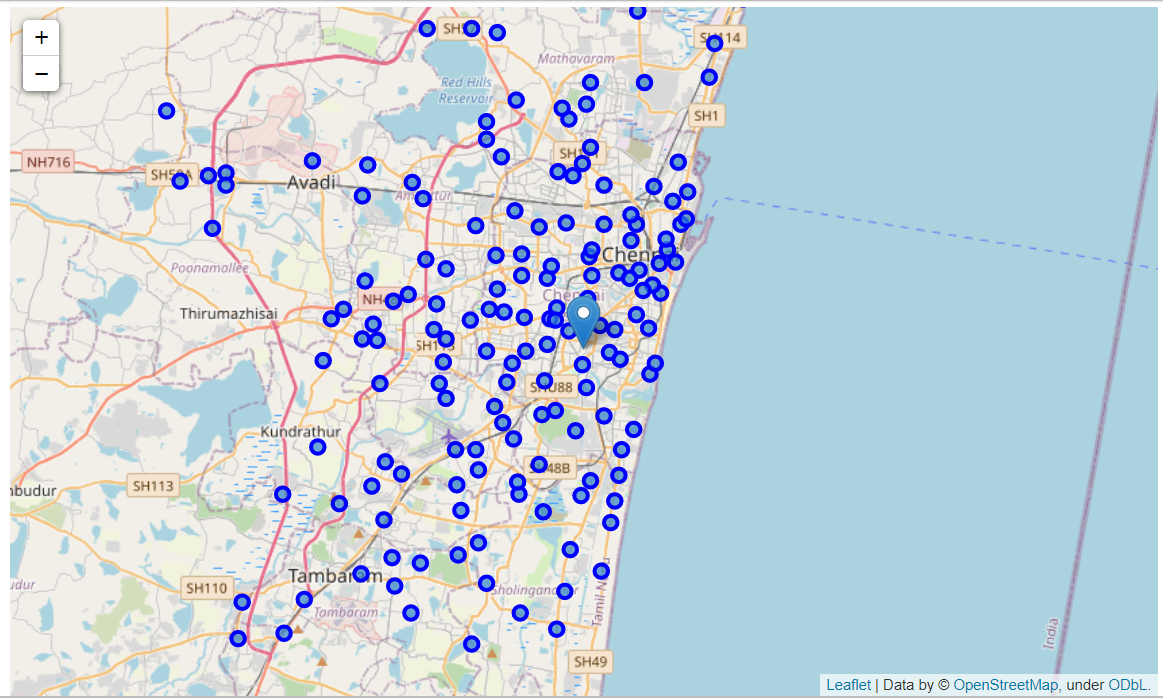

### Fetching neighborhood venues - Foursquare API

Now that we have our location candidates, let's use Foursquare API to get info of all the venues in each of the neighborhood.

In [55]:
# Foursquare credential
CLIENT_ID = 'SINBYBHJUVYI5ZFNECAKQS0EPSNQGSHR2LMCU5WRCP5WMISH'
CLIENT_SECRET = 'DCXNNXDM42HB2KEAGQL2DAS2PJGDJHFO2AQW3Y5TGK5VYSR4'
LIMIT = 100 # A default Foursquare API limit value
VERSION = 20211105

Define a function `getNearbyVenues`, to extract useful information using Foursquare API service.

In [56]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [57]:
chennai_venues = getNearbyVenues(names=chennai_df['Neighborhood'],
                                latitudes=chennai_df['Latitude'],
                                longitudes=chennai_df['Longitude'],
                                radius=2000)
chennai_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adambakkam,12.99192,80.20603,Luxe Cinemas,12.991041,80.216962,Multiplex
1,Adambakkam,12.99192,80.20603,Phoenix Market City,12.991710,80.217297,Shopping Mall
2,Adambakkam,12.99192,80.20603,IMAX®,12.990639,80.216310,Multiplex
3,Adambakkam,12.99192,80.20603,Mainland China,12.991028,80.217084,Chinese Restaurant
4,Adambakkam,12.99192,80.20603,Rajdhani,12.991081,80.217003,Rajasthani Restaurant


In [58]:
chennai_venues.shape

(5285, 7)

In [141]:
#chennai_venues.to_excel('chennai_venues1.xlsx',index=False)

In [59]:
chennai_venues.drop_duplicates(["Venue", "Venue Latitude", "Venue Longitude"], inplace=True, ignore_index=True)
chennai_venues.shape

(1648, 7)

Save `chennai_venues` dataframe to pickle file

In [60]:
with open('chennai_venues.pkl', 'wb') as f:
  pickle.dump(chennai_venues, f)

Load `chennai_venues` dataframe from pickle file

In [61]:
with open('chennai_venues.pkl', 'rb') as f:
  chennai_venues = pickle.load(f)

chennai_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adambakkam,12.99192,80.20603,Luxe Cinemas,12.991041,80.216962,Multiplex
1,Adambakkam,12.99192,80.20603,Phoenix Market City,12.991710,80.217297,Shopping Mall
2,Adambakkam,12.99192,80.20603,IMAX®,12.990639,80.216310,Multiplex
3,Adambakkam,12.99192,80.20603,Mainland China,12.991028,80.217084,Chinese Restaurant
4,Adambakkam,12.99192,80.20603,Rajdhani,12.991081,80.217003,Rajasthani Restaurant


In [62]:
chennai_venues.groupby('Neighborhood').count()[['Venue']].head()

,Venue
Neighborhood,
Adambakkam,71
Adyar,84
Alandur,19
Alapakkam,22
Alwarpet,100


In [63]:
print('There are {} uniques categories.'.format(len(chennai_venues['Venue Category'].unique())))

There are 196 uniques categories.


In [64]:
pd.DataFrame(chennai_venues['Venue Category'].unique()).head()

,0
0,Multiplex
1,Shopping Mall
2,Chinese Restaurant
3,Rajasthani Restaurant
4,Pizza Place


In [65]:
# Remove duplicates from same neighborhood 

duplicate_venues = chennai_venues.groupby(['Neighborhood','Venue']).size().reset_index(name='count')
duplicate_venues[duplicate_venues['count']!=1].head()

,Neighborhood,Venue,count
11,Adambakkam,Domino's Pizza,2
39,Adambakkam,Pizza Hut,2
44,Adambakkam,Sangeetha Restaurant,2
51,Adambakkam,Starbucks,2
52,Adambakkam,Subway,2


In [66]:
# Check for duplicate venues in the neighborhood after removal

chennai_venues.drop_duplicates(["Neighborhood","Venue"], ignore_index=True) \
            .groupby(['Neighborhood','Venue']).size().reset_index(name='count') \
            .sort_values(by='count',ascending=False).head()

,Neighborhood,Venue,count
0,Adambakkam,Apoorva Restaurant,1
1068,Kodungaiyur,Somany Tiles Showroom,1
1078,Korukkupet,Basin Bridge Station,1
1077,Korattur,Outter Ring Road,1
1076,Kolathur,SRM Grands Hotel,1


In [67]:
chennai_venues = chennai_venues.drop_duplicates(["Neighborhood","Venue"], ignore_index=True)

In [68]:
chennai_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adambakkam,12.99192,80.20603,Luxe Cinemas,12.991041,80.216962,Multiplex
1,Adambakkam,12.99192,80.20603,Phoenix Market City,12.991710,80.217297,Shopping Mall
2,Adambakkam,12.99192,80.20603,IMAX®,12.990639,80.216310,Multiplex
3,Adambakkam,12.99192,80.20603,Mainland China,12.991028,80.217084,Chinese Restaurant
4,Adambakkam,12.99192,80.20603,Rajdhani,12.991081,80.217003,Rajasthani Restaurant
...,...,...,...,...,...,...,...
1603,Virugambakkam,13.05591,80.19347,CMBT Metro Station,13.068484,80.204830,Metro Station
1604,Vyasarpadi,13.11778,80.25168,Starbucks,13.108072,80.244642,Coffee Shop
1605,Vyasarpadi,13.11778,80.25168,Perambur Park,13.109012,80.242606,Theme Park
1606,Vyasarpadi,13.11778,80.25168,Southern Railway Stadium,13.107526,80.241702,Cricket Ground


In [74]:
# Create category column based on venue categories as 'Bakery','Fast Food','Food'

list_ff = ['Fast Food Restaurant',
'Pizza Place',
'Burger Joint',
'Fried Chicken Joint',
]

list_b = ['Bakery',
'College Cafeteria',
'Cafeteria',
'Café',
'Coffee Shop',
'Chocolate Shop',
'Cupcake Shop',
'Dessert Shop',
'Donut Shop',
'Smoothie Shop',
'Snack Place',
'Tea Room',
'Indian Sweet Shop',
'Sandwich Place',
]


list_f = ['Food Court',
'Food Stand',
'Food Truck',
'Juice Bar',
'Ice Cream Shop',
'Airport Food Court'
]

conditions = [chennai_venues['Venue Category'].isin(list_b),
             chennai_venues['Venue Category'].isin(list_ff),
             chennai_venues['Venue Category'].isin(list_f)]
choices = ['Bakery','Fast Food','Food']

chennai_venues['Food_Outlet_Type'] = np.select(conditions, choices, default='Others')

#### Visualizing food outlets - Folium

Filter out only the restaurant from all the venues

In [237]:
nearby_spots = [ 'fast food restaurant',
'pizza place',
'ice cream shop',
'burger joint',
'fried chicken joint',

#####################
'bakery',
'college cafeteria',
'cafeteria',
'café',
'coffee shop',
'chocolate shop',
'cupcake shop',
'dessert shop',
'donut shop',
'smoothie shop',
'snack place',
'tea room',
'indian sweet shop',
'sandwich place',
######################
'food court',
'food stand',
'food truck',
'juice bar',
]

chennai_outlet = chennai_venues[[np.any([r in x.lower() for r in nearby_spots]) for x in chennai_venues['Venue Category']]].reset_index(drop=True)
chennai_outlet.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Food_Outlet_Type
0,Adambakkam,12.99192,80.20603,Pizza Republic,12.990987,80.198613,Pizza Place,Fast Food
1,Adambakkam,12.99192,80.20603,Subway,12.991516,80.216900,Sandwich Place,Bakery
2,Adambakkam,12.99192,80.20603,Sri Krishna Sweets,12.989584,80.218610,Snack Place,Bakery
3,Adambakkam,12.99192,80.20603,Dunkin',12.991646,80.216754,Donut Shop,Bakery
4,Adambakkam,12.99192,80.20603,"Haagen Dazs, Phoenix Market City",12.992136,80.217034,Ice Cream Shop,Food


In [238]:
chennai_outlet['Food_Outlet_Type'].unique()

array(['Fast Food', 'Bakery', 'Food'], dtype=object)

In [239]:
chennai_outlet['Venue Category'][chennai_restaurant['Food_Outlet_Type']=='Others']

Series([], Name: Venue Category, dtype: object)

Save `chennai_outlet` dataframe to pickle file

In [78]:
with open('chennai_outlet.pkl', 'wb') as f:
  pickle.dump(chennai_outlet, f)

Load `chennai_outlet` dataframe from pickle file

In [79]:
with open('chennai_outlet.pkl', 'rb') as f:
  chennai_outlet = pickle.load(f)

chennai_outlet.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Food_Outlet_Type
0,Adambakkam,12.99192,80.20603,Pizza Republic,12.990987,80.198613,Pizza Place,Fast Food
1,Adambakkam,12.99192,80.20603,Subway,12.991516,80.216900,Sandwich Place,Bakery
2,Adambakkam,12.99192,80.20603,Sri Krishna Sweets,12.989584,80.218610,Snack Place,Bakery
3,Adambakkam,12.99192,80.20603,Dunkin',12.991646,80.216754,Donut Shop,Bakery
4,Adambakkam,12.99192,80.20603,"Haagen Dazs, Phoenix Market City",12.992136,80.217034,Ice Cream Shop,Food


Percentage of each of the restaurant type

In [240]:
chennai_outlet.groupby("Venue Category").count()["Venue"].sort_values(ascending=False) / len(chennai_restaurant) * 100

Venue Category
Café                    15.294118
Fast Food Restaurant    14.117647
Pizza Place             13.882353
Ice Cream Shop          10.352941
Coffee Shop              9.647059
Bakery                   8.235294
Juice Bar                5.411765
Sandwich Place           5.176471
Dessert Shop             3.764706
Snack Place              3.529412
Burger Joint             3.294118
Donut Shop               1.411765
Food Court               1.411765
Cafeteria                1.176471
Indian Sweet Shop        1.176471
Food Truck               0.705882
Tea Room                 0.470588
College Cafeteria        0.470588
Chocolate Shop           0.235294
Airport Food Court       0.235294
Name: Venue, dtype: float64

In [241]:
chennai_outlet.groupby("Food_Outlet_Type").count()["Venue"].sort_values(ascending=False) / len(chennai_restaurant) * 100

Food_Outlet_Type
Bakery       50.588235
Fast Food    31.294118
Food         18.117647
Name: Venue, dtype: float64

The target restaurant type are

In [236]:
target_outlet = ['Bakery']

In [86]:
### Visualizing Bakery

In [243]:
# create map of Chennai using latitude and longitude values
map_chennai = folium.Map(location=[latitude, longitude], zoom_start=11)
folium.Marker([latitude, longitude], popup="Chennai city").add_to(map_chennai)

# add markers to map
for lat, lng, category in zip(chennai_outlet['Neighborhood Latitude'], chennai_outlet['Neighborhood Longitude'], chennai_outlet['Venue Category']):
    label = folium.Popup(category, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue' if category == "Bakery" else "red",
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_chennai)  

In [85]:
#map_chennai

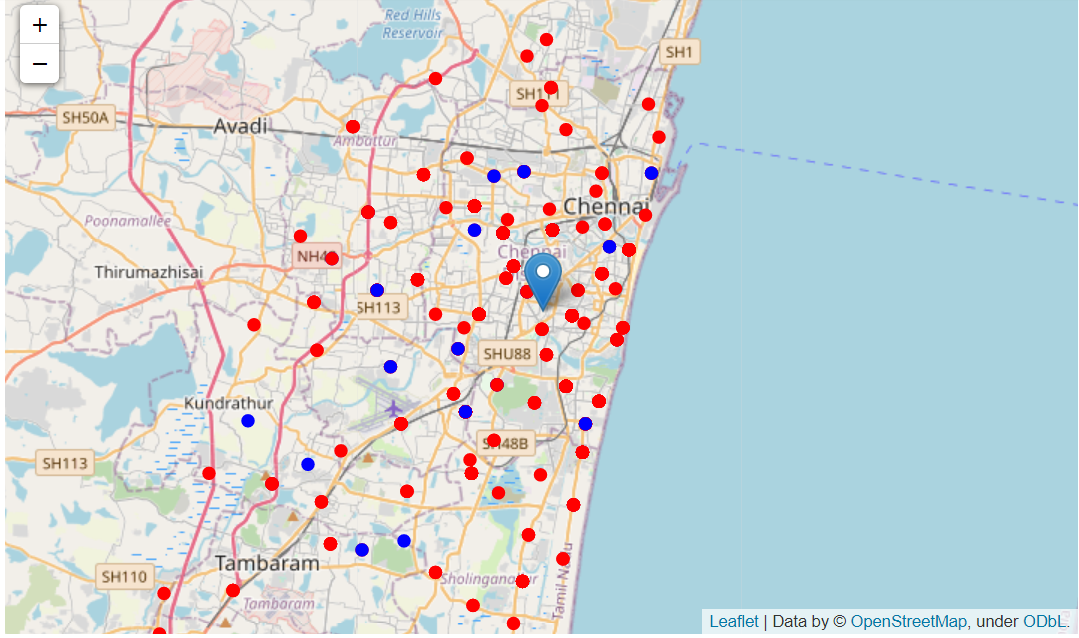

## Methodology

1. Use clustering algorithm like `KMeans` to cluster the neighborhood based on the venue frequency and analyze each cluster to select the optimal location for each of the outlet type.

2. Analyze each of the outlet type and explore the 'density' across the areas of Chennai city. Use Heatmaps to identify few promising areas with low number of bakeries in general.

3. Cluster the neighborhood based on the general venue frequency and compare the sets in each cluster to conclude the most promising and optimal location for each of the outlet type.

In [242]:
# Heatmap of food outlets
map_chennai = folium.Map([lat, lng], zoom_start=11)
folium.Marker([latitude, longitude], popup="Chennai city").add_to(map_chennai)

HeatMap(chennai_outlet[["Venue Latitude", "Venue Longitude"]].to_numpy()).add_to(map_chennai)

In [90]:
#map_chennai

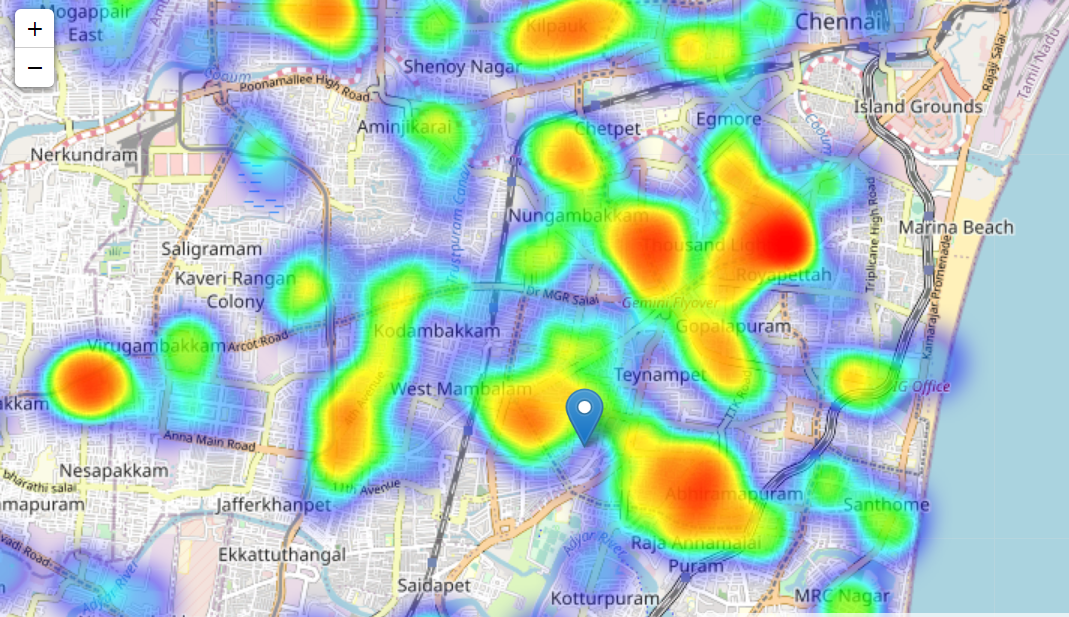

## Analysis
Cluster the neighborhoods and then analyze each of the clusters. The results will allow to identify similar neighbourhoods with the concentration of outlet type. Based on the occurrence of these outlet type in different neighbourhoods, we can decide on which neighbourhoods are most suitable to open the respective food outlets. 

In particular, we will target those neighborhood that has less target outlets and no target outlets.

We will use One-Hot encoding which allows the representation of categorical data to be more expressive. Many machine learning algorithms cannot work with categorical data directly. The categories must be converted into numbers. In our case, venue category are expressed as the mean of the frequency of occurrence of each category.

In [244]:
chennai_onehot = pd.get_dummies(chennai_venues[['Food_Outlet_Type']], prefix="", prefix_sep="")
chennai_onehot['Neighborhood'] = chennai_venues['Neighborhood']
fixed_columns = ['Neighborhood'] + list(chennai_onehot.columns.drop('Neighborhood'))
chennai_onehot = chennai_onehot[fixed_columns]

chennai_onehot.head()

,Neighborhood,Bakery,Fast Food,Food,Others
0,Adambakkam,0,0,0,1
1,Adambakkam,0,0,0,1
2,Adambakkam,0,0,0,1
3,Adambakkam,0,0,0,1
4,Adambakkam,0,0,0,1


In [245]:
chennai_onehot.shape

(1608, 5)

In [246]:
chennai_density = chennai_onehot.groupby('Neighborhood').mean().reset_index()
chennai_density.head()

,Neighborhood,Bakery,Fast Food,Food,Others
0,Adambakkam,0.136364,0.106061,0.015152,0.742424
1,Adyar,0.151899,0.050633,0.075949,0.721519
2,Alandur,0.105263,0.052632,0.052632,0.789474
3,Alapakkam,0.142857,0.190476,0.000000,0.666667
4,Alwarpet,0.181818,0.010101,0.080808,0.727273


In [247]:
chennai_density.shape

(139, 5)

Save `chennai_grouped` dataframe to pickle file

In [95]:
with open('chennai_density.pkl', 'wb') as f:
  pickle.dump(chennai_density, f)

Load `chennai_grouped` dataframe from pickle file

In [207]:
with open('chennai_density.pkl', 'rb') as f:
  chennai_density = pickle.load(f)

chennai_density.head()

,Neighborhood,Bakery,Fast Food,Food,Others
0,Adambakkam,0.136364,0.106061,0.015152,0.742424
1,Adyar,0.151899,0.050633,0.075949,0.721519
2,Alandur,0.105263,0.052632,0.052632,0.789474
3,Alapakkam,0.142857,0.190476,0.000000,0.666667
4,Alwarpet,0.181818,0.010101,0.080808,0.727273


Create a new dataframe to display the top 10 venues for each neighborhood. We will utilize the below function to achieve our task.

In [248]:
def (row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [249]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chennai_density['Neighborhood']

for ind in np.arange(chennai_density.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chennai_density.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Adambakkam,Others,Bakery,Fast Food
1,Adyar,Others,Bakery,Food
2,Alandur,Others,Bakery,Fast Food
3,Alapakkam,Others,Fast Food,Bakery
4,Alwarpet,Others,Bakery,Food
5,Alwarthirunagar,Others,Fast Food,Bakery
6,Ambattur,Others,Fast Food,Food
7,Aminjikarai,Others,Bakery,Fast Food
8,Anna Nagar,Others,Bakery,Fast Food
9,Annanur,Others,Bakery,Fast Food


### Get Neighborhood without competing venues

In [250]:
searchfor = ['Bakery']

neighborhoods_venues_sorted[neighborhoods_venues_sorted.apply(lambda x: (~x.str.contains('|'.join(searchfor), case=True, regex=True)))].dropna().head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
6,Ambattur,Others,Fast Food,Food
18,Chintadripet,Others,Fast Food,Food
22,Chrompet,Others,Fast Food,Food
67,Medavakkam,Others,Fast Food,Food
134,Velachery,Others,Fast Food,Food


### Clustering neighborhoods

In [252]:
inertia = []
for i in range(2,10):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(chennai_density.drop(labels="Neighborhood", axis=1))
    inertia.append(kmeans.inertia_)
    score = silhouette_score(chennai_density.drop(labels="Neighborhood", axis=1), kmeans.labels_, metric='euclidean')
    print(i,'Silhouetter Score: %.3f' % score)

2 Silhouetter Score: 0.446
3 Silhouetter Score: 0.502
4 Silhouetter Score: 0.507
5 Silhouetter Score: 0.512
6 Silhouetter Score: 0.525
7 Silhouetter Score: 0.529
8 Silhouetter Score: 0.546
9 Silhouetter Score: 0.565


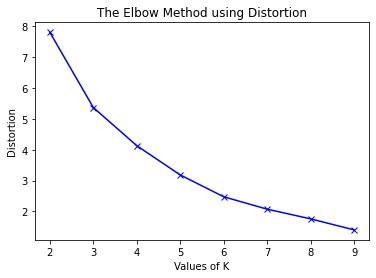

In [253]:
plt.plot(range(2, 10), inertia, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [254]:
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chennai_density.iloc[:,1:])
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3]), array([54, 58, 21,  6], dtype=int64))

In [255]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [256]:
chennai_merged = chennai_df.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how='inner').reset_index(drop=True)

chennai_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Adambakkam,12.99192,80.20603,0,Others,Bakery,Fast Food
1,Adyar,13.00303,80.25187,0,Others,Bakery,Food
2,Alandur,13.00013,80.20049,0,Others,Bakery,Fast Food
3,Alapakkam,13.04613,80.16501,2,Others,Fast Food,Bakery
4,Alwarpet,13.03471,80.25416,0,Others,Bakery,Food


Save `chennai_merged` dataframe to pickle file

In [119]:
with open('chennai_merged.pkl', 'wb') as f:
  pickle.dump(chennai_merged, f)

Load `chennai_merged` dataframe from pickle file

In [120]:
with open('chennai_merged.pkl', 'rb') as f:
  chennai_merged = pickle.load(f)

chennai_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Adambakkam,12.99192,80.20603,0,Others,Bakery,Fast Food
1,Adyar,13.00303,80.25187,0,Others,Bakery,Food
2,Alandur,13.00013,80.20049,0,Others,Bakery,Fast Food
3,Alapakkam,13.04613,80.16501,2,Others,Fast Food,Bakery
4,Alwarpet,13.03471,80.25416,0,Others,Bakery,Food


In [257]:
chennai_density = chennai_df.join(chennai_density.set_index('Neighborhood'), on='Neighborhood', how='inner').reset_index(drop=True)
chennai_density.insert(3, 'Cluster Labels', kmeans.labels_)

chennai_density.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,Bakery,Fast Food,Food,Others
0,Adambakkam,12.99192,80.20603,0,0.136364,0.106061,0.015152,0.742424
1,Adyar,13.00303,80.25187,0,0.151899,0.050633,0.075949,0.721519
2,Alandur,13.00013,80.20049,0,0.105263,0.052632,0.052632,0.789474
3,Alapakkam,13.04613,80.16501,2,0.142857,0.190476,0.000000,0.666667
4,Alwarpet,13.03471,80.25416,0,0.181818,0.010101,0.080808,0.727273


In [258]:
chennai_outlet['Food_Outlet_Type'].unique()

array(['Fast Food', 'Bakery', 'Food'], dtype=object)

In [260]:
chennai_density[['Neighborhood', 'Latitude', 'Longitude', 'Cluster Labels']+ list(chennai_outlet['Food_Outlet_Type'].unique())]

,Neighborhood,Latitude,Longitude,Cluster Labels,Fast Food,Bakery,Food
0,Adambakkam,12.99192,80.20603,0,0.106061,0.136364,0.015152
1,Adyar,13.00303,80.25187,0,0.050633,0.151899,0.075949
2,Alandur,13.00013,80.20049,0,0.052632,0.105263,0.052632
3,Alapakkam,13.04613,80.16501,2,0.190476,0.142857,0.000000
4,Alwarpet,13.03471,80.25416,0,0.010101,0.181818,0.080808
...,...,...,...,...,...,...,...
134,Velachery,12.97938,80.21845,2,0.200000,0.000000,0.200000
135,Velappanchavadi,13.05975,80.1447,3,0.500000,0.500000,0.000000
136,Villivakkam,13.10491,80.20604,3,0.000000,0.666667,0.000000
137,Virugambakkam,13.05591,80.19347,1,0.000000,0.000000,0.000000


In [261]:
# Get density of nearby spots with cluster numbers

chennai_outlet_density = chennai_density[['Neighborhood', 'Latitude', 'Longitude', 'Cluster Labels']+ list(chennai_restaurant['Food_Outlet_Type'].unique())]

chennai_outlet_density.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,Fast Food,Bakery,Food
0,Adambakkam,12.99192,80.20603,0,0.106061,0.136364,0.015152
1,Adyar,13.00303,80.25187,0,0.050633,0.151899,0.075949
2,Alandur,13.00013,80.20049,0,0.052632,0.105263,0.052632
3,Alapakkam,13.04613,80.16501,2,0.190476,0.142857,0.000000
4,Alwarpet,13.03471,80.25416,0,0.010101,0.181818,0.080808


Save `chennai_outlet_density` dataframe to pickle file

In [125]:
with open('chennai_outlet_density.pkl', 'wb') as f:
  pickle.dump(chennai_outlet_density, f)

Load `chennai_outlet_density` dataframe from pickle file

In [126]:
with open('chennai_outlet_density.pkl', 'rb') as f:
    chennai_outlet_density = pickle.load(f)

chennai_outlet_density.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,Fast Food,Bakery,Food
0,Adambakkam,12.99192,80.20603,0,0.106061,0.136364,0.015152
1,Adyar,13.00303,80.25187,0,0.050633,0.151899,0.075949
2,Alandur,13.00013,80.20049,0,0.052632,0.105263,0.052632
3,Alapakkam,13.04613,80.16501,2,0.190476,0.142857,0.000000
4,Alwarpet,13.03471,80.25416,0,0.010101,0.181818,0.080808


In [262]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color for the clusters
color = ["red", "green", "blue", "darkgoldenrod","black","orange"]

# add markers to the map
folium.Marker([latitude, longitude], popup="Chennai city").add_to(map_clusters)
markers_colors = []
for lat, lon, poi, cluster in zip(chennai_merged['Latitude'], chennai_merged['Longitude'], chennai_merged['Neighborhood'], chennai_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=color[cluster],
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)

# Add Categorical Legend
legend_html = """
<div style="position:fixed;
    background: white;
    top: 10px; 
    right: 10px; 
    width: 100px; 
    height: 85px; 
    border:2px solid grey; 
    z-index: 9999;
    font-size:14px;">
    &nbsp;<i class="fa fa-circle fa-1x" style="color:{}"></i>&nbsp;Cluster 0<br>
    &nbsp;<i class="fa fa-circle fa-1x" style="color:{}"></i>&nbsp;Cluster 1<br>
    &nbsp;<i class="fa fa-circle fa-1x" style="color:{}"></i>&nbsp;Cluster 2<br>
    &nbsp;<i class="fa fa-circle fa-1x" style="color:{}"></i>&nbsp;Cluster 3
</div>""".format(*color)
map_clusters.get_root().html.add_child(folium.Element(legend_html))

In [129]:
#map_clusters

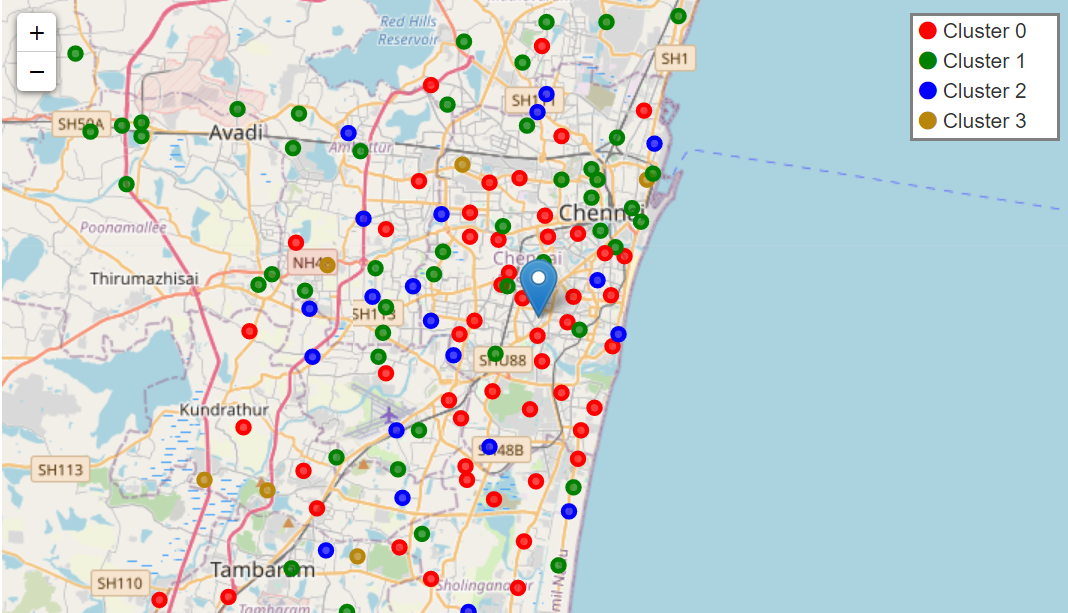

### Cluster Analysis

Each of the clusters are analyzed separately to find the opportunity of opening a new outlets with respect to each type, within each of the cluster. Each of the clusters are thoroughly examined to uncover some useful insights about the outlets and general venue density.

#### Cluster 0

In [311]:
clusternum = 0

> Top 3 common outlets

In [312]:
# Top 3 common outlets 
cluster = chennai_merged.loc[chennai_merged['Cluster Labels'] == clusternum].drop(labels=['Latitude', 'Longitude', 'Cluster Labels'], axis=1).reset_index(drop=True)
r1 = cluster.head()
display(r1)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Adambakkam,Others,Bakery,Fast Food
1,Adyar,Others,Bakery,Food
2,Alandur,Others,Bakery,Fast Food
3,Alwarpet,Others,Bakery,Food
4,Aminjikarai,Others,Bakery,Fast Food


> Most common outlet in count

In [294]:
r2 = Counter(cluster.iloc[:,1:4].to_numpy().flatten()).most_common(5)
display(r2)

[('Others', 54), ('Bakery', 52), ('Fast Food', 40), ('Food', 16)]

> Outlet fraction of all outlets

In [295]:
cluster_outlet = chennai_outlet_density.loc[chennai_outlet_density['Cluster Labels'] == clusternum].drop(labels=['Latitude', 'Longitude', 'Cluster Labels'], axis=1).reset_index(drop=True)
cluster_outlet.insert(1, 'Outlet fraction', cluster_outlet.sum(axis=1,numeric_only=True))
r3 = cluster_outlet.head()
display(r3)

,Neighborhood,Outlet fraction,Fast Food,Bakery,Food
0,Adambakkam,0.257576,0.106061,0.136364,0.015152
1,Adyar,0.278481,0.050633,0.151899,0.075949
2,Alandur,0.210526,0.052632,0.105263,0.052632
3,Alwarpet,0.272727,0.010101,0.181818,0.080808
4,Aminjikarai,0.277108,0.084337,0.144578,0.048193


> Outlet fraction of target outlets

In [296]:
target_outlet = ['Bakery']
r4 = cluster_outlet[['Neighborhood', 'Outlet fraction'] + target_outlet].head()
display(r4)

,Neighborhood,Outlet fraction,Bakery
0,Adambakkam,0.257576,0.136364
1,Adyar,0.278481,0.151899
2,Alandur,0.210526,0.105263
3,Alwarpet,0.272727,0.181818
4,Aminjikarai,0.277108,0.144578


> Target outlet count in bins 

In [297]:
cluster_outlet1 = cluster_outlet
cluster_outlet1['Outlet_fraction'] = pd.cut(cluster_outlet1['Outlet fraction'], [0, 0.25, 0.5, 0.75, 1],include_lowest=True)

g = cluster_outlet1['Outlet_fraction']
r5 = pd.concat([g.value_counts(),              
g.value_counts(normalize=True).mul(100).round(0)],axis=1,keys=('counts','percentage'))
display(r5)

,counts,percentage
"(-0.001, 0.25]",34,63.0
"(0.25, 0.5]",20,37.0
"(0.5, 0.75]",0,0.0
"(0.75, 1.0]",0,0.0


> Portion of outets in cluster as pie chart

Total neighbourhoods in cluster : 54


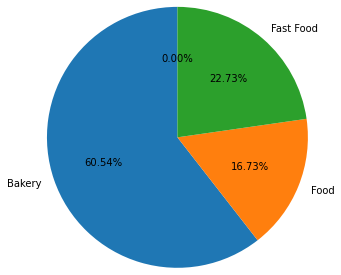

In [313]:
target_outlets = ['Bakery','Food','Fast Food']
x = np.append(cluster_outlet[target_outlets].sum().values, cluster_outlet['Outlet fraction'].sum()-cluster_outlet[target_outlets].sum().sum())
labels = np.append(cluster_outlet[target_outlets].sum().index,'')
plt.pie(x=x, labels=labels, radius=1.5, startangle=90, autopct="%.2f%%");

print('Total neighbourhoods in cluster :',len(cluster))

#### Function for cluster analysis

In [306]:
# Cluster number
clusternum = 0

def cluster_analysis(chennai_merged,chennai_outlet_density,clusternum):
    # Top 3 common outlets 
    print("Top 3 common outlets")
    cluster = chennai_merged.loc[chennai_merged['Cluster Labels'] == clusternum].drop(labels=['Latitude', 'Longitude', 'Cluster Labels'], axis=1).reset_index(drop=True)
    r1 = cluster.head()
    display(r1)

    # Most common outlet in count
    print("\nMost common outlet in count")
    r2 = Counter(cluster.iloc[:,1:4].to_numpy().flatten()).most_common(5)
    display(r2)

    # Outlet fraction of all outlets
    print("\nOutlet fraction of all outlets")
    cluster_outlet = chennai_outlet_density.loc[chennai_outlet_density['Cluster Labels'] == clusternum].drop(labels=['Latitude', 'Longitude', 'Cluster Labels'], axis=1).reset_index(drop=True)
    cluster_outlet.insert(1, 'Outlet fraction', cluster_outlet.sum(axis=1,numeric_only=True))
    r3 = cluster_outlet.head()
    display(r3)

    # Outlet fraction of target outlets
    print("\nOutlet fraction of target outlets")
    target_outlet = ['Bakery']
    r4 = cluster_outlet[['Neighborhood', 'Outlet fraction'] + target_outlet].head()
    display(r4)

    # Target outlet count in bins 
    print("\nTarget outlet count in bins")
    cluster_outlet1 = cluster_outlet
    cluster_outlet1['Outlet_fraction'] = pd.cut(cluster_outlet1['Outlet fraction'], [0, 0.25, 0.5, 0.75, 1],include_lowest=True)

    g = cluster_outlet1['Outlet_fraction']
    r5 = pd.concat([g.value_counts(),              
    g.value_counts(normalize=True).mul(100).round(0)],axis=1,keys=('counts','percentage'))
    display(r5)


    # Portion of outets in cluster as pie chart
    print("\nPortion of outets in cluster as pie chart")
    target_outlets = ['Bakery','Food','Fast Food']
    x = np.append(cluster_outlet[target_outlets].sum().values, cluster_outlet['Outlet fraction'].sum()-cluster_outlet[target_outlets].sum().sum())
    labels = np.append(cluster_outlet[target_outlets].sum().index,'')
    plt.pie(x=x, labels=labels, radius=1.5, startangle=90, autopct="%.2f%%");
    
    print('Total neighbourhoods in cluster :',len(cluster))

#### Cluster 1

Top 3 common outlets


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Annanur,Others,Bakery,Fast Food
1,Avadi,Others,Bakery,Fast Food
2,Basin Bridge,Others,Fast Food,Bakery
3,Chintadripet,Others,Fast Food,Food
4,Choolai,Others,Fast Food,Bakery



Most common outlet in count


[('Others', 58), ('Bakery', 57), ('Fast Food', 56), ('Food', 3)]


Outlet fraction of all outlets


,Neighborhood,Outlet fraction,Fast Food,Bakery,Food
0,Annanur,0.000000,0.000000,0.000000,0.000000
1,Avadi,0.000000,0.000000,0.000000,0.000000
2,Besant Nagar,0.307692,0.076923,0.115385,0.115385
3,Chintadripet,0.133333,0.066667,0.000000,0.066667
4,Choolai,0.076923,0.076923,0.000000,0.000000



Outlet fraction of target outlets


,Neighborhood,Outlet fraction,Bakery
0,Annanur,0.000000,0.000000
1,Avadi,0.000000,0.000000
2,Besant Nagar,0.307692,0.115385
3,Chintadripet,0.133333,0.000000
4,Choolai,0.076923,0.000000



Target outlet count in bins


,counts,percentage
"(-0.001, 0.25]",50,86.0
"(0.25, 0.5]",7,12.0
"(0.5, 0.75]",1,2.0
"(0.75, 1.0]",0,0.0



Portion of outets in cluster as pie chart
Total neighbourhoods in cluster : 58


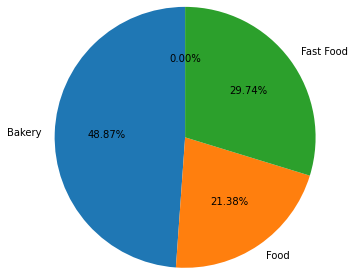

In [307]:
cluster_analysis(chennai_merged,chennai_outlet_density,1)

#### Cluster 2

Top 3 common outlets


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Alapakkam,Others,Fast Food,Bakery
1,Alwarthirunagar,Others,Fast Food,Bakery
2,Ambattur,Others,Fast Food,Food
3,Chitlapakkam,Others,Fast Food,Bakery
4,Ekkaduthangal,Others,Fast Food,Bakery



Most common outlet in count


[('Others', 21), ('Fast Food', 21), ('Bakery', 19), ('Food', 2)]


Outlet fraction of all outlets


,Neighborhood,Outlet fraction,Fast Food,Bakery,Food
0,Alapakkam,0.333333,0.190476,0.142857,0.000000
1,Alwarthirunagar,0.400000,0.200000,0.150000,0.050000
2,Ambattur,0.363636,0.181818,0.000000,0.181818
3,Chitlapakkam,0.384615,0.230769,0.076923,0.076923
4,Ekkaduthangal,0.500000,0.375000,0.125000,0.000000



Outlet fraction of target outlets


,Neighborhood,Outlet fraction,Bakery
0,Alapakkam,0.333333,0.142857
1,Alwarthirunagar,0.400000,0.150000
2,Ambattur,0.363636,0.000000
3,Chitlapakkam,0.384615,0.076923
4,Ekkaduthangal,0.500000,0.125000



Target outlet count in bins


,counts,percentage
"(0.25, 0.5]",15,71.0
"(-0.001, 0.25]",3,14.0
"(0.5, 0.75]",2,10.0
"(0.75, 1.0]",1,5.0



Portion of outets in cluster as pie chart
Total neighbourhoods in cluster : 21


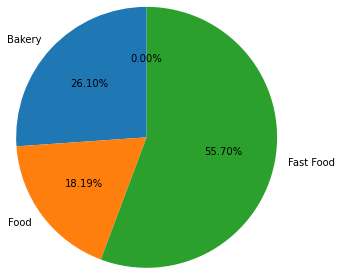

In [308]:
cluster_analysis(chennai_merged,chennai_outlet_density,2)

#### Cluster 3

Top 3 common outlets


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,George Town,Bakery,Fast Food,Food
1,MKB Nagar,Food,Bakery,Fast Food
2,Sembakkam,Bakery,Others,Fast Food
3,Thiruneermalai,Bakery,Food,Fast Food
4,Velappanchavadi,Bakery,Fast Food,Food



Most common outlet in count


[('Bakery', 6), ('Fast Food', 6), ('Food', 4), ('Others', 2)]


Outlet fraction of all outlets


,Neighborhood,Outlet fraction,Fast Food,Bakery,Food
0,George Town,1.000000,0.333333,0.333333,0.333333
1,Madhavaram Milk Colony,0.333333,0.000000,0.000000,0.333333
2,Sembakkam,0.666667,0.000000,0.666667,0.000000
3,Thiruneermalai,1.000000,0.000000,0.750000,0.250000
4,Velappanchavadi,1.000000,0.500000,0.500000,0.000000



Outlet fraction of target outlets


,Neighborhood,Outlet fraction,Bakery
0,George Town,1.000000,0.333333
1,Madhavaram Milk Colony,0.333333,0.000000
2,Sembakkam,0.666667,0.666667
3,Thiruneermalai,1.000000,0.750000
4,Velappanchavadi,1.000000,0.500000



Target outlet count in bins


,counts,percentage
"(0.75, 1.0]",3,50.0
"(0.5, 0.75]",2,33.0
"(0.25, 0.5]",1,17.0
"(-0.001, 0.25]",0,0.0



Portion of outets in cluster as pie chart
Total neighbourhoods in cluster : 6


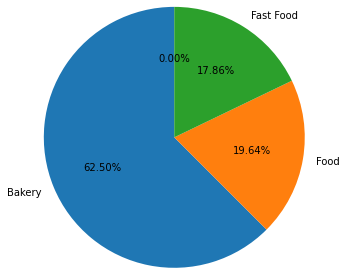

In [309]:
cluster_analysis(chennai_merged,chennai_outlet_density,3)

## Results

The summary of our analysis are,

* **Cluster 0** - Bakery comprises 60.5% of 54 neighboorhoods

* **Cluster 1** - Bakery comprises 48.8% of 58 neighboorhoods

* **Cluster 2** - Bakery comprises 26.1% of 21 neighboorhoods

* **Cluster 3** - Bakery comprises 62.5% of 6 neighboorhoods

Cluster 2 seems to have the optimal locations for opening new bakeries.

We can also apply the same approach for the larger dataset. This approach can also be applied to identify promising location for shopping malls, movie theaters and other related business. In this project, we considered only one factor, that is, venue density distribution. There are some other most useful factors like population and income of residents, real estate availability, surrounding localities, financial report etc., can be really helpful to further narrow down the choice of selecting the optimal location by the stakeholders based on specific characteristics of neighborhoods and locations.

Final decision on selecting the optimal location for the outlet will be made by stakeholders based on specific characteristics of neighborhoods and locations in every area, taking additional factors into consideration that are discussed above.